In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install opendatasets
#Import libraries
!pip3 install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pylab as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [ ]:
!pip install --user kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle datasets download mohamedhanyyy/chest-ctscan-images
!unzip chest-ctscan-images.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chest-ctscan-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-ctscan-images.zip
replace Data/test/adenocarcinoma/000108 (3).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
train_ds='./Data/train'
test_ds='./Data/test'
val_ds='./Data/valid'

In [ ]:
'''
1. Adenocarcinoma
Adenocarcinoma of the lung: Lung adenocarcinoma is the most common form of lung cancer
accounting for 30 percent of all cases overall and about 40 percent
of all non-small cell lung cancer occurrences. Adenocarcinomas are
found in several common cancers, including breast, prostate and colorectal.
Adenocarcinomas of the lung are found in the outer region of the lung
in glands that secrete mucus and help us breathe.
Symptoms include coughing, hoarseness, weight loss and weakness.

2. Large cell carcinoma
Large-cell undifferentiated carcinoma: Large-cell undifferentiated carcinoma lung cancer grows and spreads quickly and can
be found anywhere in the lung. This type of lung cancer usually accounts for 10
to 15 percent of all cases of NSCLC.
Large-cell undifferentiated carcinoma tends to grow and spread quickly.

3. Squamous cell carcinoma
Squamous cell: This type of lung cancer is found centrally in the lung,
where the larger bronchi join the trachea to the lung,
or in one of the main airway branches.
Squamous cell lung cancer is responsible for about 30 percent of all non-small
cell lung cancers, and is generally linked to smoking.

4. And the last folder is the normal CT-Scan images

'''

In [4]:
print('size adenocarcinoma',len(os.listdir(train_ds+'/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')))
print('size large',len(os.listdir(train_ds+'/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')))
print('size squamous',len(os.listdir(train_ds+'/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')))
print('size normal',len(os.listdir(train_ds+'/normal')))
#/Chest CT-Scan images Dataset/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/"

size adenocarcinoma 195
size large 115
size squamous 155
size normal 148


In [5]:
test_adenocarcinoma=os.listdir(test_ds+'/adenocarcinoma')
test_large=os.listdir(test_ds+'/large.cell.carcinoma')
test_squamous=os.listdir(test_ds+'/squamous.cell.carcinoma')
test_normal=os.listdir(test_ds+'/normal')

print(len(test_adenocarcinoma),len(test_large),len(test_squamous),len(test_normal))

120 51 90 54


In [6]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = train_ds,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = val_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [9]:
#data batches
!apt-get update
#!apt-get remove python3-pip
!pip3 install -U pip
!#pip install scipy
!-m pip install --upgrade pip
!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
!sudo apt-get install python-scipy
!pip3 install --user scipy  # install using python3
import scipy
image_batch_train, label_batch_train = next(iter(train_dataset))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_dataset.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print('0: ',dataset_labels[0])
print('1: ',dataset_labels[1])
print('2: ',dataset_labels[2])
print('3: ',dataset_labels[3])

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease              
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 163 kB in 1s (295 kB/s)
Reading package lists... Done
/bin/sh: 0: Illegal option - 
/bin/sh: 1: sudo: not found
Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 4)
0:  Adenocarcinoma_Left.Lower.Lobe_T2_N0_M0_Ib
1:  Large.Cell.Carcinoma_Left.Hilum_T2_N2_M0_Iiia
2:  Normal
3:  Squamous.Cell.Carc

In [11]:
base_model_2 = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in base_model_2.layers:
    layer.trainable = False

171327488/171317808 [==============================] - 2s 0us/step


In [ ]:
'''
A callback object can perform actions at various stages of the training (e.g. at the start or end of an epoch, before or after a single batch, etc.).​

ModelCheckpoint():

The first parameter represents the filename template.​
It can monitor either the accuracy or the loss.​
In the measure of the accuracy, higher is better (mode='max'). In the measure of loss, lower is better (mode='min').​
Setting 'save_best_only=True' ensures that the latest best model will not be overwritten.

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
 '''

In [17]:
from tensorflow.keras import Model
from tensorflow.keras import optimizers
#The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use.
x = base_model_2.output 
##A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor. This is the same thing as making a 1d-array of elements.
x = tf.keras.layers.Flatten()(x) 
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dropout 20 % of the layers
x = tf.keras.layers.Dense(train_dataset.num_classes, activation = "sigmoid")(x)
#The input layer is the input of the whole CNN.
model = Model(inputs= base_model_2.input , outputs = x)

checkpoint_filepath = './Data/ModelCheckpoint/'
# modelCheckpoint: a callback object that can perform actions at various stages of the training, and can monitor either the accuracy or the loss
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode="auto",min_delta=0.05,verbose=1)

callbacks_list = [early_stopping,checkpoint]

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='acc')
]
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 1000,callbacks=callbacks_list,verbose = 1)

Epoch 1/1000
10/10 [==============================] - 18s 1s/step - loss: 81.6792 - accuracy: 0.5232 - precision: 0.2868 - recall: 0.6101 - acc: 0.5659 - val_loss: 42.2731 - val_accuracy: 0.5243 - val_precision: 0.3054 - val_recall: 0.7083 - val_acc: 0.5992

Epoch 00001: acc improved from -inf to 0.56590, saving model to ./Data/ModelCheckpoint/
Epoch 2/1000
10/10 [==============================] - 9s 852ms/step - loss: 16.9386 - accuracy: 0.6411 - precision: 0.3923 - recall: 0.7928 - acc: 0.7166 - val_loss: 1.7182 - val_accuracy: 0.6042 - val_precision: 0.3846 - val_recall: 0.9722 - val_acc: 0.8092

Epoch 00002: acc improved from 0.56590 to 0.71662, saving model to ./Data/ModelCheckpoint/
Epoch 3/1000
10/10 [==============================] - 9s 835ms/step - loss: 3.0254 - accuracy: 0.6203 - precision: 0.3902 - recall: 0.9217 - acc: 0.7726 - val_loss: 2.2224 - val_accuracy: 0.6319 - val_precision: 0.3836 - val_recall: 0.7778 - val_acc: 0.7808

Epoch 00003: acc improved from 0.71662 to 0

In [19]:
#save model
model.save('./Data/Model')

INFO:tensorflow:Assets written to: ./Data/Model/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
y_pred=[]
model = keras.models.load_model('./Data/Model')
'''This function loads an image'''
def prepare_img(img, img_width, img_height,channels):
    img =  tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape(1, img_width, img_height, channels).astype('float32')
    img = img / 255.0
    return img
# initialize metrics
tn = fp = fn = tp = 0
print('adenocarcinoma')
for img in test_adenocarcinoma:
    img = load_img('./Data/test/adenocarcinoma/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())
    if  index_of_higher_value==0: #predicted Early_Blight
        tp+=1
    else:
        fn+=1
    print(predictions)
print('large')
for img in test_large:
    img = load_img('./Data/test/large.cell.carcinoma/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())
    if  index_of_higher_value==1: #predicted Healthy
        tp+=1
    else:
        fn+=1
    print(predictions)
print('squamous')

for img in test_squamous:
    img = load_img('./Data/test/squamous.cell.carcinoma/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())
    if  index_of_higher_value==3: #predicted Late_Blight
        tp+=1
    else:
        fn+=1
    print(predictions)
print('normal')
for img in test_normal:
    img = load_img('./Data/test/normal/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())
    if  index_of_higher_value==2: #predicted Late_Blight
        tp+=1
    else:
        fn+=1
    print(predictions)                           

# calculate precision, recall and f1_score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
accuracy=(tp+tn)/(tp+tn+fp+fn)
print("TP: " + str(tp) + "\nTN: " + str(tn) + "\nFP: " + str(fp) + "\nFN: " + str(fn) + "\n\nPrecision: " + str(precision) + "\nRecall: " + str(recall) + "\nF1 score: " + str(f1_score)+"\nAccuracy "+str(accuracy))


adenocarcinoma
[[0.90634155 0.8769925  0.04878282 0.46829173]]
[[0.95732224 0.88563985 0.00867406 0.39070925]]
[[9.9816209e-01 9.8553687e-01 1.0248088e-04 9.9685884e-01]]
[[0.9520595  0.9460473  0.12889996 0.79518014]]
[[9.981192e-01 9.777149e-01 3.641845e-04 6.658520e-01]]
[[0.9905676  0.91711724 0.0013332  0.9349822 ]]
[[9.8591679e-01 9.4338065e-01 9.7093947e-04 9.4734067e-01]]
[[0.99096584 0.9677242  0.01410873 0.762299  ]]
[[9.9960166e-01 9.9363351e-01 4.6222682e-05 9.9535358e-01]]
[[0.89990526 0.64788973 0.0335579  0.925404  ]]
[[9.8718995e-01 9.5683557e-01 7.5687666e-04 9.5605898e-01]]
[[0.9032951  0.8963364  0.125808   0.46668682]]
[[0.98041266 0.9026024  0.02971688 0.30769062]]
[[0.90507    0.35491014 0.07476886 0.30316433]]
[[9.9903297e-01 8.7574983e-01 3.3369270e-04 9.4693613e-01]]
[[9.9599153e-01 9.7273725e-01 7.9271056e-05 9.4893765e-01]]
[[0.96770847 0.9228208  0.00198979 0.55243576]]
[[0.9796026  0.9740327  0.02412582 0.86562157]]
[[0.9630244  0.95047367 0.11250563 0.4444

adenocarcinoma


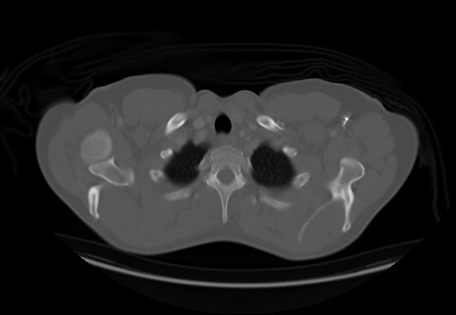

large


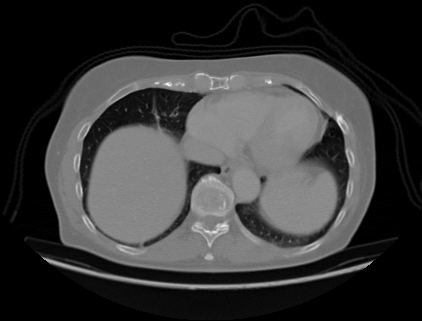

squamous


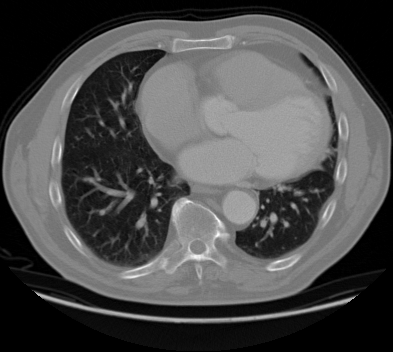

normal


In [ ]:
from IPython.display import Image 
counter=0
print('adenocarcinoma')
for i in test_adenocarcinoma:
    counter+=1
    if counter<2:
     image = Image('./Data/test/adenocarcinoma/'+i)
     display(image)

counter=0
print('large')
for i in test_large:
    counter+=1
    if counter<2:
     image = Image('./Data/test/large.cell.carcinoma/'+i)
     display(image)
        
counter=0
print('squamous')
for i in test_squamous:
    counter+=1
    if counter<2:
     image = Image('./Data/test/squamous.cell.carcinoma/'+i)
     display(image)
counter=0
print('normal')
for i in test_normal:
    counter+=1
    if counter<2:
     image = Image('./Data/test/normal/'+i)
     display(image)


In [27]:
!pip install scikit-learn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
from sklearn.metrics import classification_report
y_test=[0]*len(test_adenocarcinoma)
y_test+=[1]*len(test_large)
y_test+=[2]*len(test_normal)
y_test+=[3]*len(test_squamous)



print(classification_report(y_test, y_pred))

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/anaconda3/bin/python -m pip install --upgrade pip' command.
              precision    recall  f1-score   support

           0       0.79      0.44      0.57       120
           1       0.51      0.76      0.61        51
           2       0.00      0.00      0.00        54
           3       0.23      0.30      0.26        90

    accuracy                           0.38       315
   macro avg       0.38      0.38      0.36       315
weighted avg       0.45      0.38      0.39       315



In [ ]:
# list all data in history
print(hist.keys())
# summarize history for accuracy
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()